# Plot SHAP values for RNA modality

This jupyter notebook shows how to plot the SHAP values collected for several unimodal models with a repeated cross-validation scheme. It also shows how to combine the SHAP values associated to different predictive models to obtain a consensus ranking of features with respect to their importance for the prediction. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import tqdm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw
from sklearn.metrics import roc_auc_score

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\multipit\\')

from multipit.result_analysis.plot import plot_shap_values

In [2]:
df_omics = pd.read_csv("omics.csv", sep=";", index_col=0)
df_clinicals = pd.read_csv("clinicals.csv", index_col = 0, sep=";")

## 1. Compute SHAP values for each predictor

### 1.1 XGBoost (1-year death prediction)

In [3]:
shap_omics_xgboost_raw = pd.read_csv("classification\\shap_xgboost_100cv_OS\\Shap_RNA.csv", index_col=0)

# Compute the mean SHAP value for each sample and each feature over the 100 repeats
shap_omics_xgboost = shap_omics_xgboost_raw.groupby(level=0).mean().iloc[:, :-2]
shap_omics_xgboost.reset_index(drop=True).head()

,B lineage,CD8 T cells,Cytotoxic lymphocytes,Endothelial cells,Fibroblasts,Monocytic lineage,Myeloid dendritic cells,NK cells,Neutrophils,T cells,...,NTRK2,NTRK3,LTK,RET,NRG1,NRAS,MAP2K1,RIT1,TMB_RNA,Biopsy site
0,-0.000046,-0.000061,0.000170,-0.002639,-0.001950,-0.010122,-0.053596,-0.004653,0.000722,-0.004441,...,-0.000372,-0.000442,-0.002161,-0.004190,-0.011121,0.020717,0.000535,-0.001189,-0.004268,-0.000012
1,-0.001117,-0.001009,-0.000900,-0.003275,0.001616,-0.033531,-0.045218,0.011911,0.000892,-0.003142,...,0.002513,-0.002942,-0.003462,-0.007488,0.014353,0.034734,-0.003734,0.001358,-0.001913,-0.000310
2,0.010676,0.000682,-0.000398,-0.003216,0.001873,0.010414,0.082396,0.005641,0.000511,0.004766,...,-0.000520,-0.001892,0.000274,-0.002984,0.007779,0.071337,-0.005638,0.003498,-0.000204,-0.000015
3,0.001231,-0.000245,-0.001655,0.006247,-0.001482,-0.022117,-0.042654,-0.001476,0.000555,-0.003165,...,-0.000557,0.002593,-0.001563,-0.004521,-0.000437,0.023812,-0.002893,-0.001532,-0.006263,-0.000066
4,0.015261,0.001102,-0.000611,-0.004468,-0.006288,0.023625,-0.040676,-0.001834,0.002985,0.021671,...,-0.002667,-0.002989,0.001666,-0.005040,0.010429,0.053614,-0.005092,-0.001537,-0.003849,-0.000351


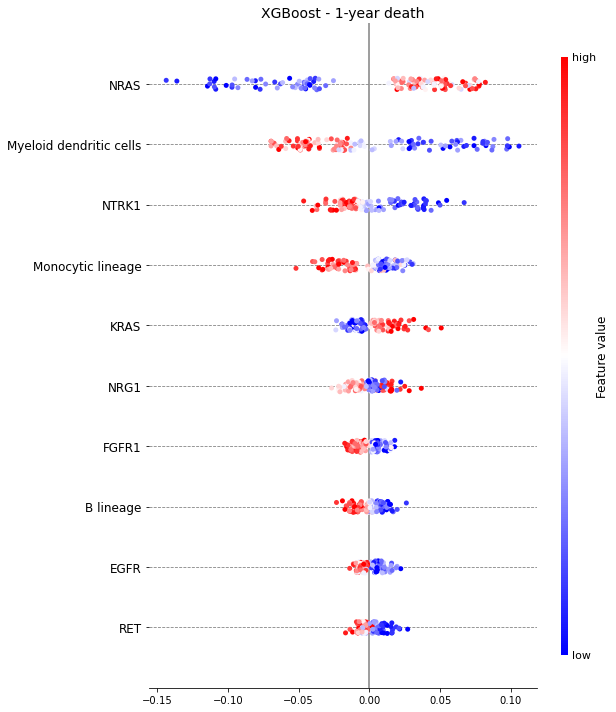

In [4]:
fig = plot_shap_values(df_omics.loc[shap_omics_xgboost.index], shap_omics_xgboost, n_best=10, figsize=(9, 10), title="XGBoost - 1-year death")

### 1.2 Logistic Regression (1-year death prediction)

In [5]:
shap_omics_LR_raw = pd.read_csv("classification\\Shap\\shap_LR_100cv_OS\\Shap_RNA.csv", index_col=0)
  
# Compute the mean SHAP value for each sample and each feature over the 100 repeats                    
shap_omics_LR = shap_omics_LR_raw.groupby(level=0).mean().iloc[:, :-2]
shap_omics_LR.reset_index(drop=True).head()

,B lineage,CD8 T cells,Cytotoxic lymphocytes,Endothelial cells,Fibroblasts,Monocytic lineage,Myeloid dendritic cells,NK cells,Neutrophils,T cells,...,NTRK2,NTRK3,LTK,RET,NRG1,NRAS,MAP2K1,RIT1,TMB_RNA,Biopsy site
0,0.002828,-3.667885e-07,-0.002032,-4.689850e-06,-5.965425e-07,-0.018154,-0.002821,-0.009878,-1.246004e-06,-0.003684,...,0.000009,0.007261,-0.000002,-0.000025,0.000752,0.012900,-2.955667e-07,0.004495,-0.001061,-0.000001
1,-0.005328,-1.428501e-06,-0.000547,-9.802448e-05,3.678220e-06,-0.013815,-0.017609,0.007297,9.415263e-07,-0.004148,...,0.000026,-0.012053,-0.000009,-0.000215,0.007772,0.123016,-9.270523e-07,0.020890,0.000028,-0.000001
2,0.020997,2.348326e-05,0.000233,9.212514e-05,-4.506698e-06,0.010897,0.099408,0.006653,-8.989653e-07,0.004826,...,0.000128,-0.010863,0.000044,0.000004,0.004909,0.006776,1.016818e-05,0.040526,-0.000040,-0.000003
3,0.006743,-1.103222e-06,-0.000347,4.468009e-07,-1.886775e-06,-0.009859,-0.121407,-0.000054,4.672998e-07,-0.005929,...,0.000009,0.020360,-0.000006,0.000030,-0.001260,0.020229,2.861908e-06,0.002501,-0.001003,-0.000009
4,0.019245,-5.830081e-06,0.001965,-2.966224e-06,-6.512199e-05,0.006009,0.000378,0.001834,9.122563e-07,0.009283,...,0.000028,0.005518,-0.000001,-0.000212,0.007125,0.062623,-3.101210e-06,0.004117,-0.000038,-0.000003


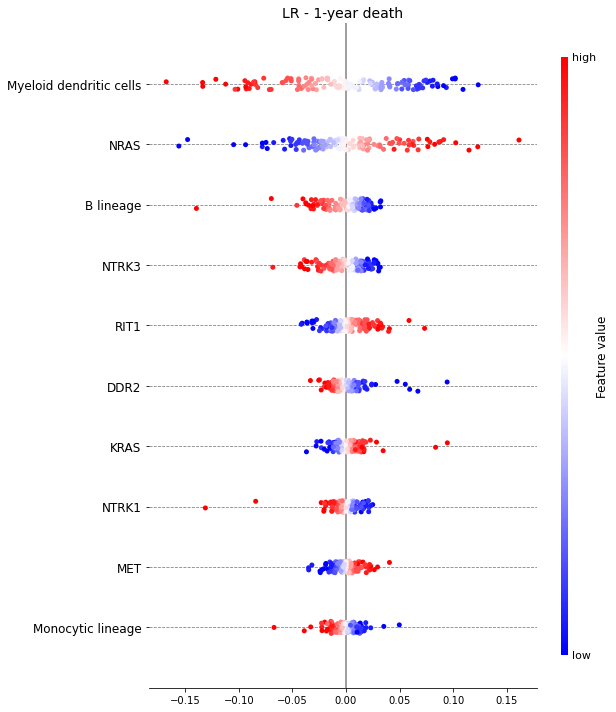

In [6]:
fig = plot_shap_values(df_omics.loc[shap_omics_LR.index], shap_omics_LR, n_best=10, figsize=(9, 10), title="LR - 1-year death")

### 1.3 Cox model (OS prediction)

In [7]:
shap_omics_Cox_raw = pd.read_csv("survival\\Shap\\shap_Cox_100cv_OS\\Shap_RNA.csv", index_col=0)

# Compute the mean SHAP value for each sample and each feature over the 100 repeats   
shap_omics_Cox = shap_omics_Cox_raw.groupby(level=0).mean().iloc[:, :-2]
shap_omics_Cox.reset_index(drop=True).head()

,B lineage,CD8 T cells,Cytotoxic lymphocytes,Endothelial cells,Fibroblasts,Monocytic lineage,Myeloid dendritic cells,NK cells,Neutrophils,T cells,...,NTRK2,NTRK3,LTK,RET,NRG1,NRAS,MAP2K1,RIT1,TMB_RNA,Biopsy site
0,0.029504,-0.005880,-0.214433,-0.002618,-0.273590,-0.041863,-0.006018,0.197270,0.096681,0.183944,...,-0.078544,0.034580,0.009224,-0.001835,0.029217,0.077512,0.058155,-0.008655,-0.315771,-0.030933
1,-0.046102,0.007573,-0.075461,0.016567,0.083877,-0.038155,-0.120068,-0.010685,0.052770,0.357678,...,-0.015010,-0.074523,-0.062527,0.068768,0.181040,0.646756,-0.108230,-0.036537,-0.007983,-0.018468
2,0.188247,-0.110234,0.027370,-0.029127,0.241383,-0.015412,0.613600,-0.080147,-0.012392,-0.171486,...,0.450466,-0.063682,0.065507,-0.001285,0.194799,0.032672,-0.259777,-0.271165,0.007257,-0.000151
3,0.064481,-0.076735,-0.037774,0.209951,-0.457779,-0.034053,-0.805480,-0.000836,0.017162,0.471569,...,-0.115966,0.104293,-0.045336,-0.006514,-0.033336,0.123748,-0.203117,-0.004284,-0.165638,0.005106
4,0.134374,-0.143456,0.158070,0.009675,-0.427093,0.010889,0.005631,-0.017799,0.036893,-0.372375,...,0.059103,0.023040,0.034998,0.034686,0.154052,0.301338,-0.190051,-0.006641,-0.011417,-0.000022


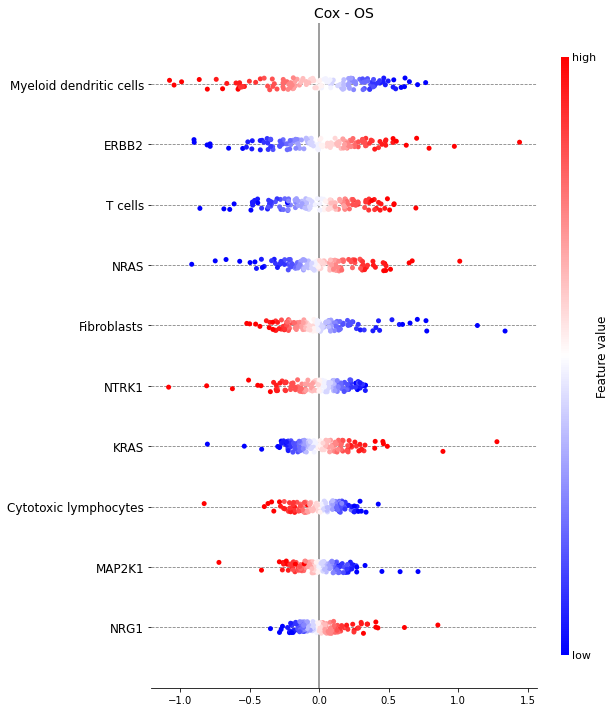

In [8]:
fig = plot_shap_values(df_omics.loc[shap_omics_Cox.index], shap_omics_Cox, n_best=10, figsize=(9, 10), title="Cox - OS")

### 1.4 Random Survival Forest (OS prediction)

In [9]:
shap_omics_RF_raw = pd.read_csv("survival\\Shap\\shap_RF_100cv_OS\\Shap_RNA.csv", index_col=0)

# Compute the mean SHAP value for each sample and each feature over the 100 repeats
shap_omics_RF = shap_omics_RF_raw.groupby(level=0).mean().iloc[:, :-2]
shap_omics_RF.reset_index(drop=True).head()

,B lineage,CD8 T cells,Cytotoxic lymphocytes,Endothelial cells,Fibroblasts,Monocytic lineage,Myeloid dendritic cells,NK cells,Neutrophils,T cells,...,NTRK2,NTRK3,LTK,RET,NRG1,NRAS,MAP2K1,RIT1,TMB_RNA,Biopsy site
0,-0.005355,-0.027795,-0.034235,-0.035611,-0.043940,-0.050742,-0.182080,-0.005250,-0.035786,-0.131692,...,-0.005594,-0.013593,-0.027019,-0.093556,-0.105872,0.095691,-0.013038,-0.057836,-0.012119,-0.018183
1,-0.038669,-0.033319,-0.046348,-0.042761,-0.011249,-0.064499,-0.234602,0.071307,-0.026414,-0.108473,...,-0.007632,-0.030154,-0.030774,-0.007364,0.293084,0.194181,-0.000657,-0.016292,0.002404,-0.000352
2,0.109010,-0.015317,-0.032350,-0.025712,0.099228,0.226979,0.678402,0.050274,-0.004743,-0.061566,...,0.070832,-0.039695,0.003904,-0.102953,0.232170,0.056428,0.019598,0.463725,0.004231,-0.001555
3,0.010208,-0.017782,-0.041158,0.023670,-0.016281,-0.074280,-0.184134,-0.027880,-0.017612,-0.067255,...,-0.012320,0.126303,-0.036546,-0.127917,-0.096383,0.138117,0.029479,-0.057557,-0.041169,-0.010118
4,0.142377,0.354802,0.027465,-0.035471,-0.031780,-0.011180,-0.178201,-0.018674,-0.015085,0.514970,...,-0.011940,-0.026638,0.007909,0.013291,0.247359,0.123876,0.003482,-0.037832,-0.004156,-0.001593


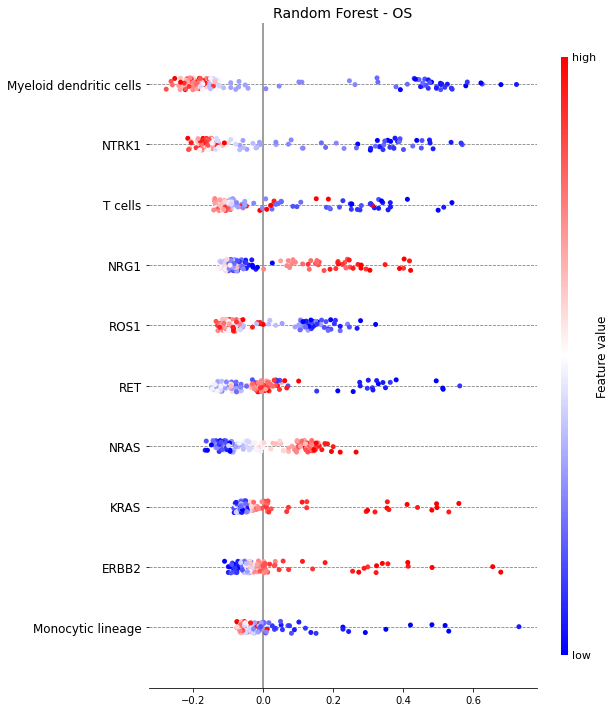

In [10]:
fig = plot_shap_values(df_omics.loc[shap_omics_RF.index], shap_omics_RF, n_best=10, figsize=(9, 10), title="Random Forest - OS")

## 2. Combine SHAP values over the 4 models

### 2.1 Compute correlations between features and associated SHAP values

We only keep features that have a constant correlation sign (either -1 or +1) across the 4 predictive models. For instance *Myeloid dendritic cells* feature is negatively correlated with its associated SHAP values for XGboost, LR, Cox, and Random Survival Forest models. It is thus considered as a "robust important feature".

In [11]:
def extract_correlation_signs(data, shap_values):
    corr_matrix = data.join(shap_values, rsuffix = "_shap").corr(method="spearman").iloc[33:, :33].values
    return np.sign(np.diagonal(corr_matrix)).reshape(-1, 1)

xgboost_sign = extract_correlation_signs(df_omics.loc[shap_omics_xgboost.index].iloc[:, :-1], shap_omics_xgboost.iloc[:, :-1])
LR_sign = extract_correlation_signs(df_omics.loc[shap_omics_LR.index].iloc[:, :-1], shap_omics_LR.iloc[:, :-1])
RF_sign = extract_correlation_signs(df_omics.loc[shap_omics_RF.index].iloc[:, :-1], shap_omics_RF.iloc[:, :-1])
Cox_sign = extract_correlation_signs(df_omics.loc[shap_omics_Cox.index].iloc[:, :-1], shap_omics_Cox.iloc[:, :-1])

In [12]:
df_signs = pd.DataFrame(np.hstack([xgboost_sign, LR_sign, RF_sign, Cox_sign]), columns = ["XGboost", "LR", "RF", "Cox"], index = shap_omics_xgboost.columns[:-1])
bool_mask = (df_signs.sum(axis=1) == -4) | (df_signs.sum(axis=1) == 4)

### 2.2 Rank features with respect to their absolute mean SHAP value

**Note:** Here we only rank the "robust important features", filtering out the ones whose correlation sign was not consistent across the four models (see code above).

In [13]:
df_rank = pd.concat([np.abs((shap_omics_xgboost.iloc[:, :-1].T)[bool_mask]).mean(axis=1).rank(ascending=True).rename("XGBoost"),
                     np.abs((shap_omics_LR.iloc[:, :-1].T)[bool_mask]).mean(axis=1).rank(ascending=True).rename("LR"),
                     np.abs((shap_omics_RF.iloc[:, :-1].T)[bool_mask]).mean(axis=1).rank(ascending=True).rename("RF"),
                     np.abs((shap_omics_Cox.iloc[:, :-1].T)[bool_mask]).mean(axis=1).rank(ascending=True).rename("Cox")],
                    axis=1
                   )
df_rank

,XGBoost,LR,RF,Cox
B lineage,7.0,11.0,6.0,8.0
Fibroblasts,2.0,1.0,7.0,11.0
Monocytic lineage,10.0,6.0,8.0,3.0
Myeloid dendritic cells,12.0,13.0,13.0,13.0
KRAS,9.0,9.0,9.0,9.0
MET,4.0,7.0,1.0,5.0
ROS1,6.0,4.0,11.0,1.0
FGFR1,8.0,2.0,5.0,4.0
FGFR2,5.0,3.0,3.0,2.0
NTRK1,11.0,8.0,12.0,10.0


### 2.3 Aggregate the ranks (weighted average of the ranks obtained with the different models)

We define the aggregated rank of each feature with the following formula:

\begin{equation}
r_f^{cons} = \dfrac{1}{s_1 + s_2 + s_3 + s_4} \sum_{i=1}^{4} s_i r_i^f
\end{equation}

Where $s_i$ corresponds to the score (i.e., AUC or C-index) of the model i and is equal to max(0, $score_i - 0.5$) and $r_i^f$ corresponds to the rank of feature $f$ for model i.   

**Note 1:** Performance scores were computed with all the patients with the modality of interest available (e.g. The AUC associated with the 1-year death prediction of an XGboost model and estimated with a repeated cross-validation scheme was 0.663 (for 134 patients with the RNA modality available)).

**Note 2:** The aggregated ranks are normalized with respect to the total number of consensus features.

In [14]:
# 1. Weighted average
xgboost_per = 0.663 - 0.5
lr_perf = 0.627 - 0.5
rf_perf = 0.624 - 0.5
cox_perf = 0.542 - 0.5
final_importance = (df_rank.apply(lambda row: (1/(xgboost_per+lr_perf+rf_perf+cox_perf))*(xgboost_per*row["XGBoost"] + lr_perf*row["LR"] + rf_perf*row["RF"] + cox_perf*row["Cox"]),
                                  axis=1)
                           .sort_values(ascending=False)
                   )

# 2. Normalize by the number of consensus features
final_importance = (final_importance/df_rank.shape[0]) * df_signs[bool_mask]["XGboost"].loc[final_importance.index]

# 3. Add annotations
final_importance = final_importance.to_frame().rename(columns={0: "Consensus importance"})
final_importance["Impact"] = 1*(final_importance["Consensus importance"] > 0)
final_importance = final_importance.replace(to_replace = {"Impact": {0: "Lower risk", 1: "Increase risk"}})
final_importance

,Consensus importance,Impact
Myeloid dendritic cells,-0.972503,Lower risk
NRAS,0.908738,Increase risk
NTRK1,-0.795715,Lower risk
KRAS,0.692308,Increase risk
B lineage,-0.610324,Lower risk
Monocytic lineage,-0.592105,Lower risk
ROS1,-0.487854,Lower risk
FGFR1,-0.395749,Lower risk
NTRK3,-0.367915,Lower risk
MET,0.316296,Increase risk


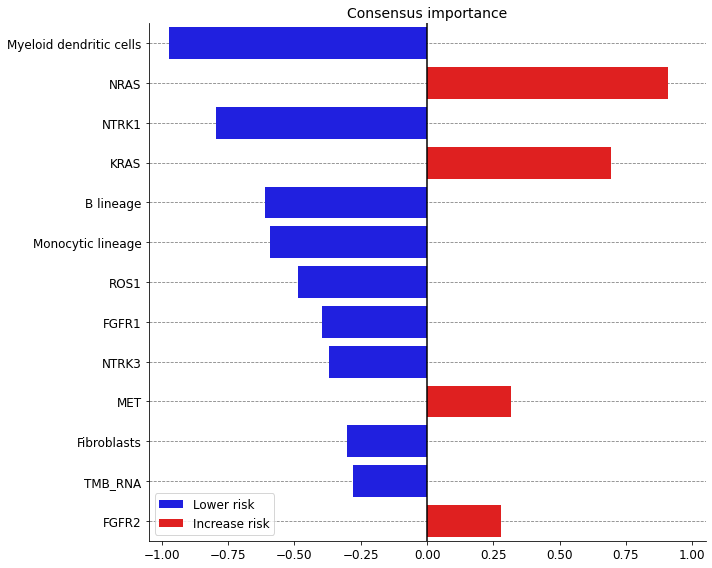

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=final_importance.reset_index(), orient="h", x="Consensus importance", y="index", hue="Impact", palette=["blue", "red"], dodge=False, ax=ax)

ax.set(xlabel=None, ylabel=None)
ax.set_axisbelow(True)
ax.yaxis.grid(color="gray", linestyle="dashed")
ax.legend(fontsize=12)
ax.axvline(x=0, color="k")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Consensus importance", fontsize=14)
ax.set_xlim(-1.05, 1.05)
plt.tight_layout()
sns.despine()

## 3. Compute correlations between consensus features

Text(226.82954545454544, 0.5, 'Correlation')

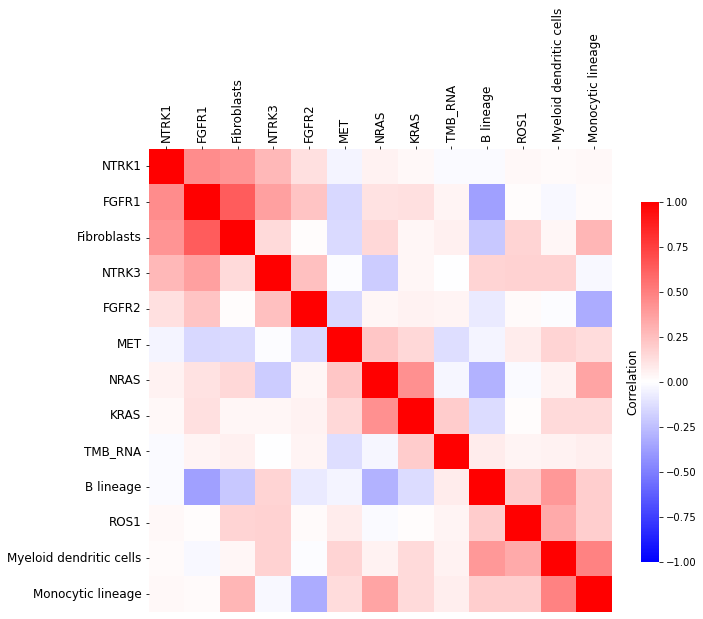

In [16]:
cg = sns.clustermap(df_omics[final_importance.index].corr(method="spearman"), vmin=-1, vmax=1, cmap="bwr",  cbar_kws={'shrink': 1.3})
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.xaxis.set_tick_params(labelsize=12, rotation=90)
cg.ax_heatmap.yaxis.set_tick_params(labelsize=12)
cg.ax_cbar.set_position([0.86, 0.25, 0.025, 0.5])
cg.ax_cbar.set_ylabel("Correlation", labelpad=-70, fontsize=12)

## 4. Univariate tests

### 4.1 Univariate test for OS prediction (C-index)

In [17]:
def bootstrap_surv(data, data_test, risk_score, n_b = 1000, disable=True):
    """
    data: Structured array of shape (n_samples_train,)
        Data to estimate the censoring distribution from (see sksruv.metrics.concordance_index_ipcw)
    
    data_test: Structured array of shape (n_samples,)
        Survival time and event indicator of test data
        
    risk_score: array of shape (n_samples,)
        risk_score
        
    n_b: int
        Number of bootstrap samples. Default is 1000
    
    disable: bool. Default is True
        Disable tqdm
    """
    n_patients = len(data_test)
    c_unos = []
    for i in tqdm(range(n_b), disable=disable):
        boot_sample = np.random.choice(np.arange(n_patients) , size=n_patients)
        c_unos.append(concordance_index_ipcw(data, data_test[boot_sample], risk_score[boot_sample])[0])
    return c_unos

def permutation_test_surv(data, data_test, risk_score, n_p = 1000, disable=True):
    """
    data: Structured array of shape (n_samples_train,)
        Data to estimate the censoring distribution from (see sksruv.metrics.concordance_index_ipcw)
    
    data_test: Structured array of shape (n_samples,)
        Survival time and event indicator of test data
        
    risk_score: array of shape (n_samples,)
        risk_score
        
    n_p: int
        Number of permutation samples. Default is 1000
    
    disable: bool. Default is True
        Disable tqdm
    """
    c_unos = []
    for i in tqdm(range(n_p), disable=disable):
        np.random.shuffle(risk_score)
        c_unos.append(concordance_index_ipcw(data, data_test, risk_score)[0])
    return c_unos

In [24]:
bool_mask = df_clinicals['OS'].isnull()
target = Surv.from_arrays(event = 1*(df_clinicals.loc[~bool_mask, "Statut Vital"]=="Decede").values,
                          time = df_clinicals.loc[~bool_mask, "OS"].values)

dic = {'cindex': [], 'pval_left': [], 'pval_right': [], 'boot_left': [], 'boot_right': []}

for feature in tqdm(final_importance.index, total=final_importance.shape[0]):
    
    temp = pd.concat([df_omics[feature], df_clinicals.loc[~bool_mask, ["OS", "Statut Vital"]]], axis=1).dropna()
    
    target_test = Surv.from_arrays(event = 1*(temp["Statut Vital"]=="Decede").values,
                                   time = temp["OS"].values)
    
    c_index = concordance_index_ipcw(target, target_test, temp[feature].values)[0]
    p_cindex = permutation_test_surv(target, target_test, risk_score = np.copy(temp[feature].values))
    boot_cindex = bootstrap_surv(target, target_test, risk_score = np.copy(temp[feature].values))
    
    dic['cindex'].append(c_index)
    dic['pval_left'].append((np.sum(np.array(p_cindex) <= c_index) + 1)/(len(p_cindex)+1))
    dic['pval_right'].append((np.sum(np.array(p_cindex) >= c_index) + 1)/(len(p_cindex)+1))
    dic['boot_left'].append(np.quantile(np.array(boot_cindex), 0.025))
    dic['boot_right'].append(np.quantile(np.array(boot_cindex), 0.975))

df_tests = pd.DataFrame(dic, index =final_importance.index) 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:31<00:00,  7.07s/it]


In [25]:
df_tests["adjusted_pvalue"] = multipletests(df_tests[['pval_left', 'pval_right']].min(axis=1).values,
                                            method='fdr_bh')[1]
df_tests

,cindex,pval_left,pval_right,boot_left,boot_right,adjusted_pvalue
Myeloid dendritic cells,0.401703,0.001998,0.999001,0.336083,0.469753,0.025974
NRAS,0.585145,0.992008,0.008991,0.513537,0.655507,0.049351
NTRK1,0.417541,0.014985,0.986014,0.348820,0.492976,0.049351
KRAS,0.516243,0.693307,0.307692,0.424479,0.592642,0.333333
B lineage,0.422202,0.018981,0.982018,0.344191,0.502500,0.049351
Monocytic lineage,0.435446,0.050949,0.950050,0.361497,0.518247,0.094620
ROS1,0.449236,0.097902,0.903097,0.377599,0.528620,0.159091
FGFR1,0.461426,0.138861,0.862138,0.383403,0.544979,0.200577
NTRK3,0.471907,0.206793,0.794206,0.394614,0.544144,0.246753
MET,0.494086,0.415584,0.585415,0.398247,0.576490,0.415584


### 4.2 Univariate tests for 1-year death prediction (AUC)

In [20]:
def bootstrap_clf(y_true, y_score, n_b = 1000, disable=True):
    """
    y_true: array of shape (n_samples,)
        True binary labels
    
    y_score: array of shape (n_samples,)
        Prediction score
        
    n_b: int
        Number of bootstrap samples. Default is 1000
    
    disable: bool. Default is True
        Disable tqdm
    """
    n_patients = len(y_true)
    aucs = []
    for i in tqdm(range(n_b), disable=disable):
        boot_sample = np.random.choice(np.arange(n_patients) , size=n_patients)
        aucs.append(roc_auc_score(y_true[boot_sample], y_score[boot_sample]))
    return aucs


def permutation_test_clf(y_true, y_score, n_p = 1000, disable=True):
    """
    y_true: array of shape (n_samples,)
        True binary labels
    
    y_score: array of shape (n_samples,)
        Prediction score
        
    n_p: int
        Number of permutation samples. Default is 1000
    
    disable: bool. Default is True
        Disable tqdm
    """
    aucs = []
    for i in tqdm(range(n_p), disable=disable):
        np.random.shuffle(y_true)
        aucs.append(roc_auc_score(y_true, y_score))
    return aucs

In [22]:
bool_mask = (df_clinicals['OS'].isnull()) | ((df_clinicals['OS'] <= 365) & (df_clinicals['Statut Vital'] == "Vivant"))

dic_aucs = {'auc': [], 'pval_left': [], 'pval_right': [], 'boot_left': [], 'boot_right': []}

for feature in tqdm(final_importance.index, total=final_importance.shape[0]):
    
    temp = pd.concat([df_omics[feature], df_clinicals.loc[~bool_mask, ["OS", "Statut Vital"]]], axis=1).dropna()
    y_true = 1*(temp['OS'] <= 365).values
    
    auc = roc_auc_score(y_true = y_true, y_score = temp[feature].values)
    p_auc = permutation_test_clf(y_true, np.copy(temp[feature].values), n_p = 1000)
    boot_auc = bootstrap_clf(y_true, np.copy(temp[feature].values), n_b = 1000)
    
    dic_aucs['auc'].append(auc)
    dic_aucs['pval_left'].append((np.sum(np.array(p_auc) <= auc) + 1)/(len(p_auc)+1))
    dic_aucs['pval_right'].append((np.sum(np.array(p_auc) >= auc) + 1)/(len(p_auc)+1))
    dic_aucs['boot_left'].append(np.quantile(np.array(boot_auc), 0.025))
    dic_aucs['boot_right'].append(np.quantile(np.array(boot_auc), 0.975))

df_tests_aucs = pd.DataFrame(dic_aucs, index =final_importance.index) 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.03s/it]


In [23]:
df_tests_aucs["adjusted_pvalue"] = multipletests(df_tests_aucs[['pval_left', 'pval_right']].min(axis=1).values, method='fdr_bh')[1]
df_tests_aucs

,auc,pval_left,pval_right,boot_left,boot_right,adjusted_pvalue
Myeloid dendritic cells,0.299060,0.000999,1.000000,0.427348,0.643591,0.006494
NRAS,0.674207,0.998002,0.002997,0.380286,0.605504,0.012987
NTRK1,0.365893,0.008991,0.992008,0.388981,0.604827,0.019481
KRAS,0.619859,0.989011,0.011988,0.339284,0.545669,0.022263
B lineage,0.314336,0.000999,1.000000,0.429191,0.644988,0.006494
Monocytic lineage,0.364865,0.007992,0.993007,0.417118,0.621728,0.019481
ROS1,0.410987,0.061938,0.939061,0.305947,0.523812,0.100649
FGFR1,0.450059,0.190809,0.810190,0.394007,0.636226,0.206710
NTRK3,0.372650,0.008991,0.992008,0.333093,0.523875,0.019481
MET,0.564924,0.880120,0.122877,0.371033,0.601713,0.159740
